# Word Embedding & Genre Classification
Project Overview
This project builds a complete NLP pipeline for analyzing and classifying song lyrics using custom-trained word embeddings. It combines classical machine learning, modern deep learning, and multiple semantic evaluation techniques to explore how meaning is captured in text representations.

The workflow starts from raw MetroLyrics data and progresses through preprocessing, word embedding training, sentiment modeling, semantic visualization, and multi-method genre classification, including a convolutional neural network.


In [ ]:
# !pip install --no-cache-dir nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/lisa_polo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lisa_polo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lisa_polo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lisa_polo/nltk_data...


True

In [ ]:
# !pip install --no-cache-dir \
#     pandas \
#     seaborn \
#     matplotlib \
#     tqdm \
#     joblib \
#     scikit-learn \
#     torch \
#     torchvision \
#     torchaudio \
#     cython\
#     scipy==1.11.4\
#     fastparquet\
#     pyarrow

### Imports

In [ ]:
import re, random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from scipy.spatial.distance import cosine, euclidean
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
from joblib import Parallel, delayed

# seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


## Dataset
The MetroLyrics song lyrics dataset contains song-level metadata and full lyrics for a large collection of tracks


In [ ]:
df = pd.read_parquet('https://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet?raw=true')
df = df.sort_index()
df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",1961,oh baby you know i gon na cut right chase some...,1145
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,827,if search for tenderness it hard find you love...,643
7,waiting,2009,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting\nWaiting, w...",2112,waiting waiting waiting waiting waiting waitin...,1433
9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,"N-n-now, honey\nYou better sit down and look a...",1595,n n honey you better sit look around cause mus...,931
11,telephone,2009,beyonce-knowles,Pop,Hello hello baby you called\nI can't hear a th...,2688,hello hello baby called i hear thing i got ser...,1886


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49976 entries, 0 to 266555
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       49976 non-null  object
 1   year       49976 non-null  int64 
 2   artist     49976 non-null  object
 3   genre      49976 non-null  object
 4   lyrics     49976 non-null  object
 5   num_chars  49976 non-null  int64 
 6   sent       49976 non-null  object
 7   num_words  49976 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.4+ MB


In [ ]:
(df.genre.value_counts(normalize=True)*100).round(2)

genre
Rock       23.48
Pop        21.61
Hip-Hop    19.47
Metal      18.89
Country    16.56
Name: proportion, dtype: float64

The dataset contains several thousand songs (rows) and no exotic or irregular data types, mostly non-null fields, though some songs may have missing or very short lyrics. 
We see that the main genre is Rock, followed by Pop, but mostly the  genres differ in size not so much
We can use it for large-scale text processing and embedding training.

## Preprocessing 

We need to prepare raw lyrics for embedding training and classification. To do it wa need to  clean and normalize the text so that the later models work with consistent, meaningful tokens.
So we:
* convert all text to lowercase,
* remove punctuation and non-alphabetic characters,
* tokenize the lyrics,
* remove stopwords,
* lemmatize words to unify different word forms (e.g., “running” → “run”).

After cleaning each song, we build: global word frequencies, and per-genre word frequencies, which are later used for genre-specific analysis, selecting representative words

Finally, we remove rare words (frequency ≤ 5) to reduce noise and improve Word2Vec training stability. Each review is filtered again to exclude these rare tokens, producing a clean, consistent corpus for all downstream tasks.

In [ ]:
stopwords_eng = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
punct_re = re.compile("[^a-z]")

def process_review(text):
    text = punct_re.sub(" ", text.lower())
    tokens = word_tokenize(text)
    clean = []
    for w in tokens:
        if w in stopwords_eng: continue
        if len(w) < 2: continue
        w = lemmatizer.lemmatize(w)
        clean.append(w)
    return clean

clear_reviews = []
word_counts = Counter()
word_counter_per_genre = defaultdict(Counter)

for lyr, g in tqdm(zip(df['lyrics'], df['genre']), total=len(df)):
    words = process_review(lyr)
    clear_reviews.append(words)
    word_counts.update(words)
    word_counter_per_genre[g].update(words)

rare_threshold = 5
rare_set = {w for w,c in word_counts.items() if c <= rare_threshold}

def filter_review(r):
    return [w for w in r if w not in rare_set]

no_rare_words = Parallel(n_jobs=2)(
    delayed(filter_review)(r) for r in clear_reviews
)

no_rare_count = Counter()
for r in no_rare_words:
    no_rare_count.update(r)


100%|████████████████████████████████████████████████████████████| 49976/49976 [00:37<00:00, 1325.27it/s]


In [ ]:
windows = [2, 10, 20]
models = {}
VECTOR_SIZE = 300

for w in windows:
    print(f"\nTraining Word2Vec model with window={w} ...")

    model = Word2Vec(
        sentences=no_rare_words,
        vector_size=VECTOR_SIZE,
        window=w,
        sg=1,
        min_count=2,
        epochs=15,
        negative=10,
        workers=12
    )

    models[w] = model

2025-12-03 14:36:57,263 : INFO : collecting all words and their counts
2025-12-03 14:36:57,264 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-12-03 14:36:57,352 : INFO : PROGRESS: at sentence #10000, processed 1335742 words, keeping 29092 word types
2025-12-03 14:36:57,441 : INFO : PROGRESS: at sentence #20000, processed 2729861 words, keeping 33653 word types



Training Word2Vec model with window=2 ...


2025-12-03 14:36:57,527 : INFO : PROGRESS: at sentence #30000, processed 4022214 words, keeping 34979 word types
2025-12-03 14:36:57,612 : INFO : PROGRESS: at sentence #40000, processed 5323105 words, keeping 35858 word types
2025-12-03 14:36:57,700 : INFO : collected 36418 word types from a corpus of 6694056 raw words and 49976 sentences
2025-12-03 14:36:57,701 : INFO : Creating a fresh vocabulary
2025-12-03 14:36:57,752 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 36418 unique words (100.00% of original 36418, drops 0)', 'datetime': '2025-12-03T14:36:57.752147', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.11.0-1016-nvidia-x86_64-with-glibc2.39', 'event': 'prepare_vocab'}
2025-12-03 14:36:57,752 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 6694056 word corpus (100.00% of original 6694056, drops 0)', 'datetime': '2025-12-03T14:36:57.752668', 'gensim': '4.4.0', 'python': '3.


Training Word2Vec model with window=10 ...


2025-12-03 14:38:28,855 : INFO : PROGRESS: at sentence #30000, processed 4022214 words, keeping 34979 word types
2025-12-03 14:38:28,945 : INFO : PROGRESS: at sentence #40000, processed 5323105 words, keeping 35858 word types
2025-12-03 14:38:29,034 : INFO : collected 36418 word types from a corpus of 6694056 raw words and 49976 sentences
2025-12-03 14:38:29,035 : INFO : Creating a fresh vocabulary
2025-12-03 14:38:29,084 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 36418 unique words (100.00% of original 36418, drops 0)', 'datetime': '2025-12-03T14:38:29.084325', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.11.0-1016-nvidia-x86_64-with-glibc2.39', 'event': 'prepare_vocab'}
2025-12-03 14:38:29,084 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 6694056 word corpus (100.00% of original 6694056, drops 0)', 'datetime': '2025-12-03T14:38:29.084627', 'gensim': '4.4.0', 'python': '3.


Training Word2Vec model with window=20 ...


2025-12-03 14:43:51,241 : INFO : PROGRESS: at sentence #30000, processed 4022214 words, keeping 34979 word types
2025-12-03 14:43:51,356 : INFO : PROGRESS: at sentence #40000, processed 5323105 words, keeping 35858 word types
2025-12-03 14:43:51,478 : INFO : collected 36418 word types from a corpus of 6694056 raw words and 49976 sentences
2025-12-03 14:43:51,478 : INFO : Creating a fresh vocabulary
2025-12-03 14:43:51,529 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 36418 unique words (100.00% of original 36418, drops 0)', 'datetime': '2025-12-03T14:43:51.529162', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.11.0-1016-nvidia-x86_64-with-glibc2.39', 'event': 'prepare_vocab'}
2025-12-03 14:43:51,529 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 6694056 word corpus (100.00% of original 6694056, drops 0)', 'datetime': '2025-12-03T14:43:51.529624', 'gensim': '4.4.0', 'python': '3.

In [ ]:
def check_similar_word(word):
  fig, axes = plt.subplots(1, len(windows), figsize=(18, 5))
  for i, window in enumerate(windows):
    similar = models[window].wv.most_similar(word)
    words, percentage = zip(*similar)
    sns.barplot(x=percentage, y=words, ax=axes[i])
    axes[i].set_title(f'Window size: {window}')
    axes[i].set_xlabel('Similarity')
    if i == 0:
        axes[i].set_ylabel('Words')
    else:
        axes[i].set_ylabel('')

  plt.show()

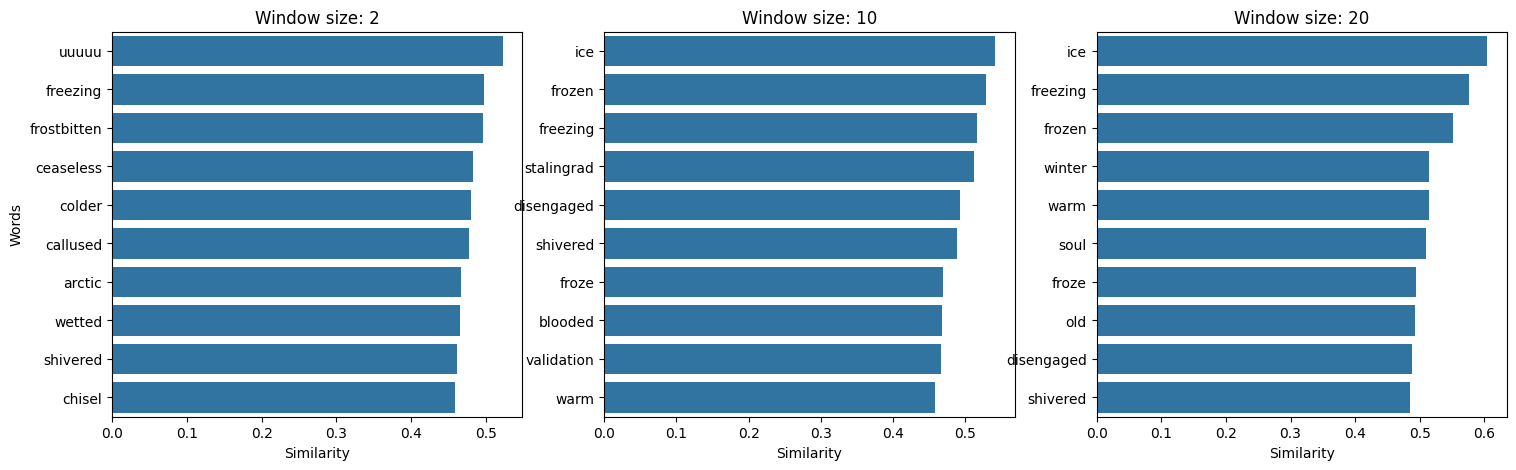

In [ ]:
check_similar_word('cold')

We are going to continue with window=10, cause these results gave much better balance between global and local meanings

In [ ]:
model = models[10]

### Word Vector Algebra

To evaluate whether the trained embeddings capture meaningful relationships between words, we use simple vector arithmetic examples such as:

* king − man + woman ≈ queen
* happy − good + bad ≈ sad

This test checks whether the model encodes consistent semantic structure in its vector space. If the embeddings capture real-world relationships, subtracting and adding word vectors should yield another semantically related word. Comparing cosine and Euclidean distances between the computed vector and the expected word helps assess how well the model represents these analogies.


In [ ]:
def compare(a,b,c,expected):
    v = model.wv[a] - model.wv[b] + model.wv[c]
    u = model.wv[expected]
    print(a,b,c,'->',expected,'| cos:',cosine(v,u),'| euc:',euclidean(v,u))


In [ ]:
compare('king', 'man', 'woman', 'queen')
compare('queen', 'woman', 'man', 'king')
compare('queen', 'woman', 'man', 'box') 

king man woman -> queen | cos: 0.5668878555297852 | euc: 4.417177200317383
queen woman man -> king | cos: 0.5818251669406891 | euc: 4.417177200317383
queen woman man -> box | cos: 0.8448222130537033 | euc: 5.317158222198486


### Sentiment Regression

To understand whether the learned word embeddings capture emotional meaning, we use them to predict sentiment scores for individual words. We match words from our vocabulary to an external sentiment lexicon (SemEval-2015), train regression models to map word vectors to sentiment values, and evaluate how well the embeddings encode positive–negative polarity. This also allows us to estimate sentiment for words not included in the original lexicon.

In [ ]:
lex = pd.read_csv('SemEval2015-English-Twitter-Lexicon.txt', sep='\t')
lex.columns=['word','value']
lex['word'] = lex['word'].str.replace('#','').str.lower()

lex

,word,value
0,loves,0.992
1,amazing,0.984
2,peaceful,0.984
3,greatness,0.977
4,fantastic,0.969
...,...,...
1309,scumbag,0.016
1310,failure,0.016
1311,killyourself,0.016
1312,kill,0.016


In [ ]:
vocab = set(no_rare_count.keys())
matched = lex[lex.word.isin(vocab)]

X = np.vstack([model.wv[w] for w in matched.word if w in model.wv])
y = matched.value.values

ridge = Ridge()
ridge.fit(X,y)

mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=300)
mlp.fit(X,y)


,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True


In [ ]:
mlp_scores = cross_val_score(
    mlp, X, y, cv=5, scoring="neg_mean_squared_error"
)
ridge_scores = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')


In [ ]:
print("Ridge CV MSE:", -ridge_scores.mean())
print("MLP   CV MSE:", -mlp_scores.mean())


Ridge CV MSE: 0.07554268633852797
MLP   CV MSE: 0.08114033700120306


We expected that non-linear models capture embedding structure better, here the linear Ridge model outperformed the MLP. This suggests that the sentiment information encoded in the learned Word2Vec embeddings is largely linear and can be effectively captured without additional model complexity. We're going with ridge

In [ ]:
# Predict sentiment for unmatched
unmatched = [w for w in vocab if w not in matched.word.values and w in model.wv]
Xm = np.vstack([model.wv[w] for w in unmatched])
yp = ridge.predict(Xm)

sent_df = pd.DataFrame({'word':unmatched,'sentiment':yp})
sent_df.sort_values('sentiment', ascending=False).head(10)

,word,sentiment
17735,caribbean,1.789411
8451,hallelujah,1.767975
22673,fabulous,1.567158
5697,barbie,1.504085
8197,bouquet,1.463185
14519,beyonc,1.451487
1537,finer,1.431989
31134,volare,1.422916
8404,lily,1.405644
16316,denver,1.397730


In [ ]:
sent_df.sort_values('sentiment', ascending=True).head(10)


,word,sentiment
24287,pinne,-0.544805
18799,wah,-0.541323
29115,blamed,-0.538894
14080,lea,-0.497074
12524,eaten,-0.473697
9514,numbskull,-0.471595
2371,boris,-0.470940
21213,rie,-0.458335
19576,oodles,-0.448408
24674,mangled,-0.435601


### Sentiment Prediction Conclusion

Using the Ridge sentiment regressor, we estimated polarity scores for words that were not part of the original SemEval lexicon. The top positive words (e.g., caribbean, hallelujah, fabulous) reflect cheerful, celebratory, or aesthetically pleasant concepts, which aligns well with intuition. The most negative words (e.g., mangled, blamed, numbskull) correspond to harm, blame, or insults, also matching expected sentiment. This indicates that the learned word embeddings contain meaningful emotional structure and that the regression model is able to recover sentiment trends even for words it has never seen before.

## Text classification
To evaluate how well different text representations capture genre information in song lyrics, we tested three approaches. First, we use a Bag-of-Words model with bigram features and trained a Multinomial Naive Bayes classifier as a strong baseline. Next, we replaced word counts with dense semantic features by averaging Word2Vec vectors for each song and trained a Logistic Regression classifier on top. Finally, we applied TF-IDF weights to the embeddings to emphasize more informative words before averaging. Comparing these representations shows how increasing semantic richness changes classification performance.

### BOW + Naive Bayes
We start with a Bag-of-Words baseline using unigrams and bigrams. This method ignores semantic meaning and relies only on token frequencies, but it is fast and robust. We use Multinomial Naive Bayes, which is well-suited for sparse count features and serves as a strong classical benchmark before introducing embeddings.

In [ ]:
label_encoder = LabelEncoder()
df['genre_label'] = label_encoder.fit_transform(df['genre'])
y_all = df['genre_label']
texts = [' '.join(r) for r in no_rare_words]

# BoW
vec = CountVectorizer(ngram_range=(1,2), min_df=5)
Xbow = vec.fit_transform(texts)
Xtr_nb,Xte_nb,ytr_nb,yte_nb = train_test_split(Xbow, y_all, test_size=0.3, random_state=42)
nb = MultinomialNB()
nb.fit(Xtr_nb,ytr_nb)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [ ]:
def evaluate_classifier(y_true, y_pred, title):
    print(title)
    print("Accuracy:", accuracy_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

Bag-of-Words + Naive Bayes
Accuracy: 0.6115520576268926


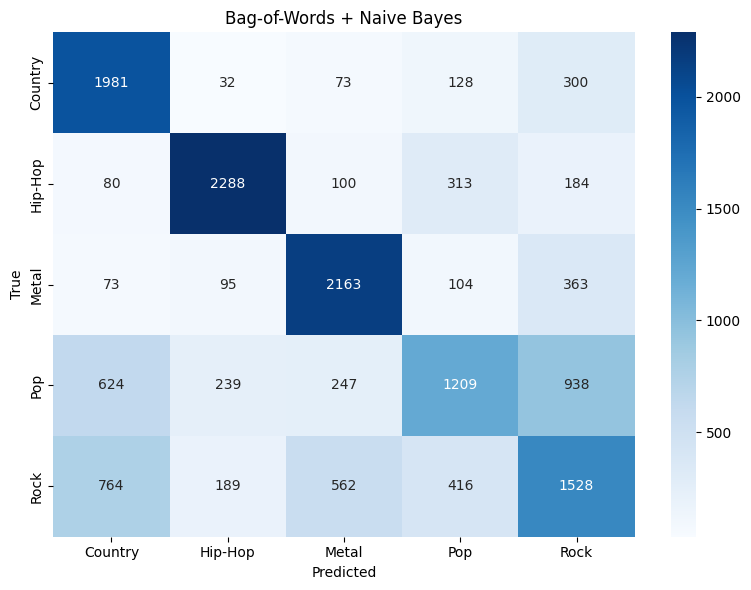

In [73]:
y_pred_nb = nb.predict(Xte_nb)
evaluate_classifier(yte_nb, y_pred_nb, "Bag-of-Words + Naive Bayes")


### Average Word2Vec Embeddings + Logistic Regression
Now we average all Word2Vec vectors in each song, collapse the entire lyrics into a single 300-dimensional embedding representing its overall meaning. Logistic Regression is trained on top to see how well the embeddings separate genres. This approach tests whether semantic similarity learned by the embedding model is useful for genre prediction compared to simple token counts.

In [74]:
# Avg embeddings
def avg_vec(words):
    vecs=[model.wv[w] for w in words if w in model.wv]
    return np.mean(vecs,axis=0) if vecs else np.zeros(VECTOR_SIZE)

Xemb = np.vstack([avg_vec(r) for r in no_rare_words])
Xtr_emb,Xte_emb,ytr_emb,yte_emb = train_test_split(Xemb, y_all, test_size=0.3, random_state=42)

logr = LogisticRegression(max_iter=1000).fit(Xtr_emb,ytr_emb)


Averaged vectors + Logistic Regression
Accuracy: 0.6161542052958047


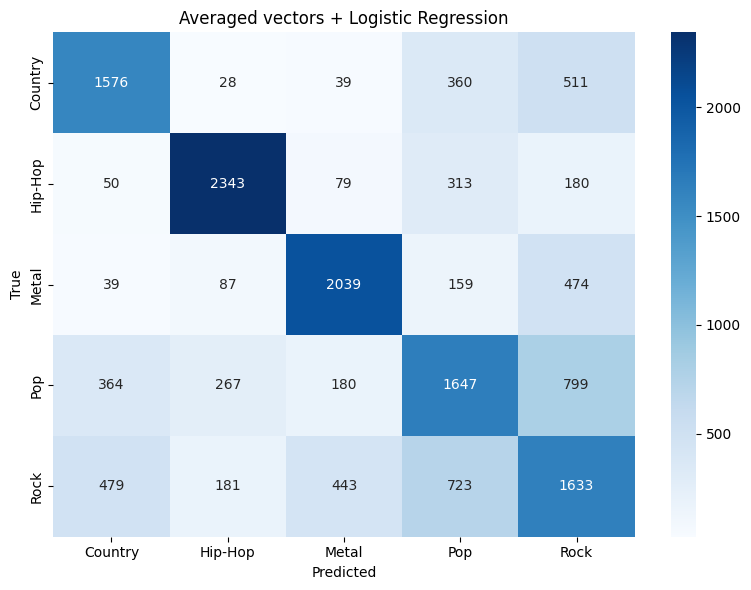

In [75]:
y_pred_emb = logr.predict(Xte_emb)
evaluate_classifier(yte_emb, y_pred_emb, "Averaged vectors + Logistic Regression")

### Tf-IDF Weighted Embeddings
TF-IDF weighting reduces the influence of common words and increases the importance of genre-specific terms. By weighting each embedding by its TF-IDF score before averaging, we create richer document vectors emphasizing informative vocabulary. This helps evaluate whether smarter weighting improves embedding-based classification.

In [66]:
tfv = TfidfVectorizer(vocabulary=model.wv.key_to_index)
Xtf = tfv.fit_transform(texts)

def weighted_vec(idx, words):
    feats = Xtf[idx].toarray().flatten()
    names = tfv.get_feature_names_out()
    wmap = {names[i]:feats[i] for i in range(len(names)) if feats[i]>0}
    vecs=[]
    weights=0
    for w in words:
        if w in model.wv and w in wmap:
            vecs.append(model.wv[w]*wmap[w])
            weights+=wmap[w]
    return np.sum(vecs,axis=0)/weights if weights>0 else np.zeros(VECTOR_SIZE)

Xw = np.vstack([weighted_vec(i,r) for i,r in enumerate(no_rare_words)])


TF-IDF Weighted Embeddings + Logistic Regression
Accuracy: 0.567398119122257


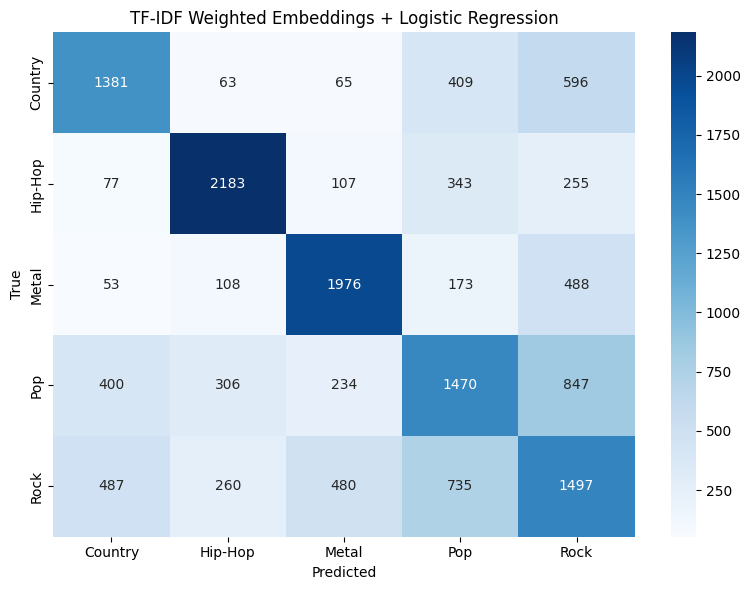

In [76]:
Xtr_w, Xte_w, ytr_w, yte_w = train_test_split(Xw, y_all, test_size=0.3, random_state=42)
logr_w = LogisticRegression(max_iter=1000).fit(Xtr_w, ytr_w)
y_pred_w = logr_w.predict(Xte_w)
evaluate_classifier(yte_w, y_pred_w, "TF-IDF Weighted Embeddings + Logistic Regression")


### TextCNN
Now we preserve word order and treat the song as a sequence of embeddings. A convolutional neural network (TextCNN) applies multiple filters across this sequence to detect local semantic patterns such as common lyric phrases, emotional cues, or stylistic structures. CNNs allow the model to learn n-gram-like features directly from embeddings

In [78]:
MAX_LEN=128
emb_dim=VECTOR_SIZE

mat=[]
for r in no_rare_words:
    r=r[:MAX_LEN]
    M=np.zeros((MAX_LEN,emb_dim))
    for i,w in enumerate(r):
        if w in model.wv: M[i]=model.wv[w]
    mat.append(M)

Xcnn = torch.tensor(mat, dtype=torch.float32)
ycnn = torch.tensor(df['genre_label'].values, dtype=torch.long)

Xtr,Xte,ytr,yte = train_test_split(Xcnn, ycnn, test_size=0.3, random_state=42)

trds = TensorDataset(Xtr,ytr)
teds = TensorDataset(Xte,yte)

trl = DataLoader(trds,batch_size=32,shuffle=True)
tel = DataLoader(teds,batch_size=32)

class TextCNN(nn.Module):
    def __init__(self, emb_dim=300, filters=128):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(1, filters, (k,emb_dim)) for k in [2,3,4]
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(filters*3, len(df['genre_label'].unique()))
    def forward(self,x):
        x = x.unsqueeze(1)
        xs=[]
        for c in self.convs:
            o=torch.relu(c(x)).squeeze(3)
            o=torch.max_pool1d(o,o.size(2)).squeeze(2)
            xs.append(o)
        x=torch.cat(xs,1)
        x=self.dropout(x)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = TextCNN().to(device)
opt = optim.Adam(cnn.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(5):
    cnn.train()
    for xb,yb in trl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = cnn(xb)
        loss=crit(out,yb)
        loss.backward()
        opt.step()


In [79]:
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in tel:
        xb = xb.to(device)
        out = cnn(xb)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds)


TextCNN (Word2Vec embeddings)
Accuracy: 0.6419662509170947


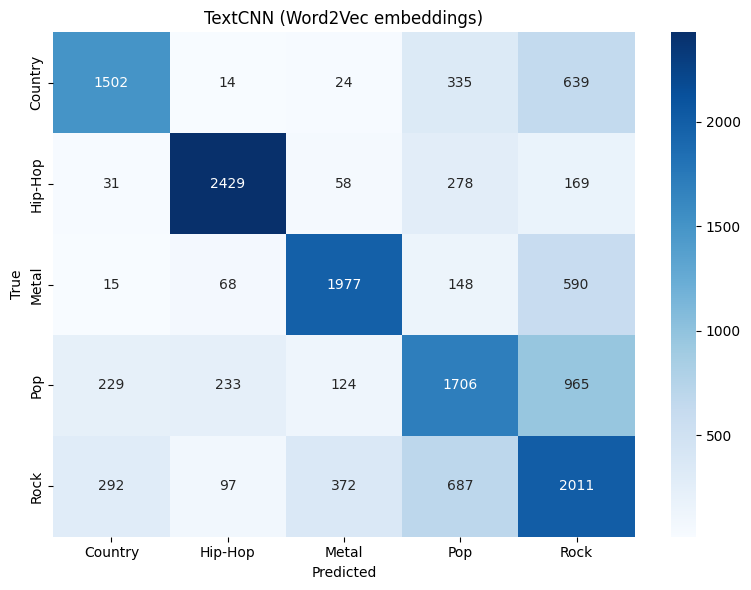

In [81]:
evaluate_classifier(y_true, y_pred, "TextCNN (Word2Vec embeddings)")


## Classification conclusion
The Bag-of-Words model with Naive Bayes achieved 61% accuracy, and averaging Word2Vec embeddings with Logistic Regression reached the same level, showing that dense semantic representations alone do not outperform strong count-based baselines in this case. TF-IDF weighting of embeddings performed worse at 57%, likely because lyrics contain many stylistic or repetitive words that do not benefit from TF-IDF emphasis. The best performance came from the TextCNN at 64%, suggesting that preserving word order and learning local phrase-level patterns provides meaningful additional signal beyond averaging. Overall, CNN-based models offer the strongest results, but traditional methods remain surprisingly effective for this task


# General Conclusion
This project built a full NLP pipeline for analyzing song lyrics, starting from text preprocessing and ending with sentiment prediction and genre classification. After cleaning the data and removing rare tokens, we trained several Word2Vec models and selected the window-10 version based on its stronger semantic behavior in similarity and analogy checks. These embeddings were then used to train a sentiment regressor, where Ridge Regression performed best, showing that the learned sentiment structure is largely linear.

For genre classification, we compared multiple text representations. Bag-of-Words with Naive Bayes and averaged Word2Vec embeddings both reached about 61% accuracy, while TF-IDF–weighted embeddings performed worse. The best performance came from a TextCNN model operating on full embedding sequences, achieving 64%, indicating that preserving word order and local phrase patterns adds meaningful predictive value. Overall, the pipeline demonstrates how preprocessing choices and representation levels—from token counts to sequence-based neural models—affect performance across sentiment and genre tasks.